# Exploring optimization over the VGG loss

In [1]:
from torchvision import models
from torchvision import transforms
import torch
import torch.nn as nn
import cv2 as cv2 # opencv computer vision library
from PIL import Image
import os
import sys

dirname = os.path.abspath(os.path.join(os.getcwd(), "..", "lib"))
sys.path.append(dirname)

from display import imshow
from vgg import VGGFeatures
from utils import preprocess, deprocess

## Importing the images

array([[<Axes: title={'center': 'Eye style'}>,
        <Axes: title={'center': 'Chair'}>]], dtype=object)

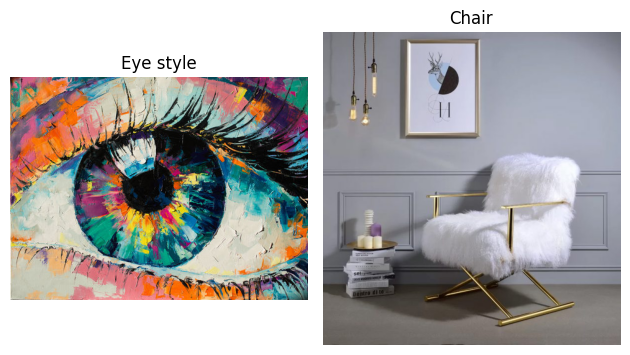

In [2]:
# Style
eye_style = Image.open("../data/style/eye.jpg")
# Objects or scenes
chair_image = Image.open("../data/scenes/chair.jpg")

imshow([eye_style, chair_image], ['Eye style', 'Chair'])

In [3]:
eye_style_prep = preprocess(eye_style)
chair_image_prep = preprocess(chair_image)

## Getting the features

In [4]:
vgg_model = VGGFeatures()

In [5]:
feature_style = vgg_model(eye_style_prep)
feature_chair_image = vgg_model(chair_image_prep)

In [6]:
loss = 0
criterion = nn.MSELoss()
for feature in feature_style.keys():
    loss = criterion(feature_style[feature],feature_chair_image[feature])
print("The loss is",loss.item())

The loss is 3.3359861373901367


## Brainstorming a model

According to the paper ([Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://arxiv.org/abs/1603.08155)), we will need three main block:
- Downsampling
- Residual Connections
- Upsampling

**CustomConvolutionalLayer** is a custom Convolutional layer block, with a reflexion padding to prevent edge artifacts.

In [7]:
class CustomConvolutionalLayer(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=1, stride=1):
        super(CustomConvolutionalLayer, self).__init__()
        ref_padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(ref_padding)
        self.convolution2d = nn.Conv2d(in_size, out_size, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.convolution2d(out)
        return out

The **residual block** is as defined in this paper [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385). It basically prevents the vanishing gradient problem, and also allowing for the original sample to skip some connections. It is especially usefull in our case since we keep the original image shape more or less.

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv_layer1 = CustomConvolutionalLayer(channels, channels, kernel_size=3, stride=1)
        self.batch_norm1 = nn.BatchNorm2d(channels, affine=True)
        self.relu = nn.ReLU()
        self.conv_layer2 = CustomConvolutionalLayer(channels, channels, kernel_size=3, stride=1)
        self.batch_norm2 = nn.BatchNorm2d(channels, affine=True)

    def forward(self, x):
        out = self.relu(self.batch_norm1(self.conv_layer1(x)))
        out = self.batch_norm2(self.conv_layer2(out))
        out = out + x
        return out

The **UpsampleConvLayer** class defines a custom layer that combines upsampling and convolution operations. This layer is designed to handle upscaling in a way that avoids common artifacts in image generation, providing a smoother and higher-quality output compared to using transposed convolutions alone. Let's break down its purpose and the operations it performs.

In [9]:
class UpsampleConvolutionalLayer(nn.Module):
    def __init__(self, in_size, out_size, kernel_size, stride=1, upsample=None):
        super(UpsampleConvolutionalLayer, self).__init__()
        self.upsample = upsample
        ref_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(ref_padding)
        self.convolution2d = nn.Conv2d(in_size, out_size, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.convolution2d(out)
        return out

## Assembling our model

In [10]:
class DeepStleX_Beta(torch.nn.Module):
    def __init__(self, downsample_layers=[(3,9,1),(48,3,2),(128,)], num_residual_blocks=3, upsample_layers=[(128,3,2),(48,3,2),(3,)]):
        """
        Params:
        - downsample_layers: list of (size, kernel_size, stride)
        """
        super(DeepStleX_Beta, self).__init__()
        for i in range(len(upsample_layers)):
            if type(upsample_layers[i])!=list and type(upsample_layers[i])!=tuple:
                upsample_layers[i] = (upsample_layers[i],)
        for i in range(len(downsample_layers)):
            if type(downsample_layers[i])!=list and type(downsample_layers[i])!=tuple:
                downsample_layers[i] = (downsample_layers[i],)
        assert downsample_layers[-1][0]==upsample_layers[0][0]

        # Non-linearities
        self.relu = nn.ReLU()

        # Initial convolution layers
        self.down_layers = []
        for i in range(1, len(downsample_layers)):
            self.down_layers.append(
                CustomConvolutionalLayer(downsample_layers[i-1][0], downsample_layers[i][0], kernel_size=downsample_layers[i-1][1], stride=downsample_layers[i-1][2])
                )
            self.down_layers.append(nn.BatchNorm2d(downsample_layers[i][0], affine=True))
            self.down_layers.append(self.relu)
        # Residual layers
        self.residual_layers = []
        for i in range(num_residual_blocks):
            self.residual_layers.append(ResidualBlock(upsample_layers[0][0]))
        # Upsampling Layers
        self.up_layers = []
        for i in range(1, len(upsample_layers)):
            if(i<len(upsample_layers)-1):
                self.up_layers.append(
                    UpsampleConvolutionalLayer(upsample_layers[i-1][0], upsample_layers[i][0], kernel_size=upsample_layers[i-1][1], stride=1, upsample=upsample_layers[i-1][2])
                )
                self.up_layers.append(nn.BatchNorm2d(upsample_layers[i][0], affine=True))
                self.up_layers.append(self.relu)
            else:
                self.up_layers.append(
                    CustomConvolutionalLayer(upsample_layers[i-1][0], upsample_layers[i][0], kernel_size=upsample_layers[i-1][1], stride=1)
                )

    def forward(self, X):
        y = X
        for layer in self.down_layers:
            y = layer(y)

        for layer in self.residual_layers:
            y = layer(y)

        for layer in self.up_layers:
            y = layer(y)

        return y

## Trying it out

In [11]:
model = DeepStleX_Beta()

In [12]:
output = model(chair_image_prep)
output.shape

torch.Size([1, 3, 256, 256])

array([[<Axes: >]], dtype=object)

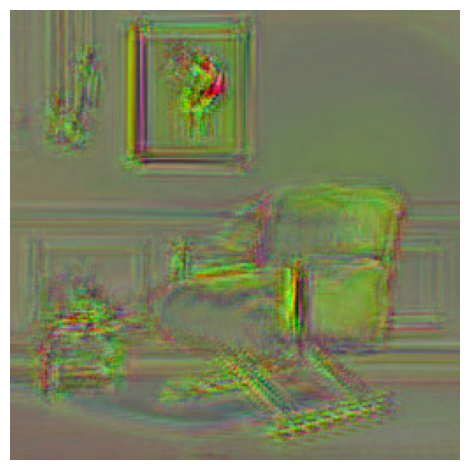

In [13]:
imshow(deprocess(output))